In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.sparse import diags
from tangelo.linq.helpers.circuits.statevector import StateVector
from tangelo.linq import get_backend, Circuit, Gate
import math
from itertools import product
from openfermion import get_sparse_operator, get_ground_state
from tangelo.toolboxes.operators import QubitOperator
import numpy as np
from numpy import pi, exp
from tangelo.toolboxes.ansatz_generator.ansatz_utils import get_qft_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import pauli_op_to_gate, recursive_trotter_suzuki_decomposition
from tangelo.toolboxes.circuits.lcu import sign_flip

In [2]:
lam_eh = 0.7
lam_ee = 4
lam_eli = 2.25


def vpot_harm(xpts, r):
    return 1/2*r*xpts**2

def vinteract_harm(xpts):
    n1=len(xpts)
    fullgrid = np.zeros(n1**2, dtype=float)
    for n in range(n1):
        fullgrid[n*n1:(n+1)*n1] = 1/np.sqrt(lam_ee+(xpts[n]-xpts)**2)
    return fullgrid

def qu_vpot(vals, order='lsq_first'):
    n_qubits=round(math.log2(len(vals)))
    new_vals = vals.copy()
    if order == "msq_first":
        new_vals = new_vals.reshape([2]*n_qubits).transpose(list(reversed(range(n_qubits)))).flatten() 
    v_op =QubitOperator()
    for i in product(["I", "Z"], repeat=n_qubits):
        tup = tuple([(j, op) for j, op in enumerate(i) if op != "I"])
        qu_op = QubitOperator(tup)
        v = get_sparse_operator(qu_op, n_qubits=n_qubits)
        v_op += (diags(new_vals).dot(v)).trace()*QubitOperator(tup)
    v_op /= 2**n_qubits
    return v_op

/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


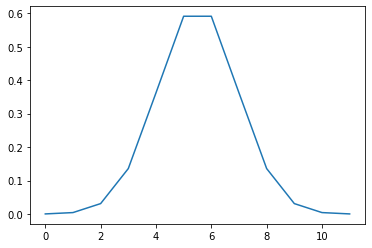

In [3]:
from scipy.linalg import dft
from scipy.fft import fft
n_pts_s = 12
dx_s = 0.7
dp = 2*np.pi/n_pts_s/dx_s
p = np.empty(n_pts_s, dtype=float)
for i in range(n_pts_s):
    p[i] = dp*i - (n_pts_s//2)*dp
ptot_s = np.diag(p**2)
dvrpts_s = np.linspace(-dx_s*(n_pts_s//2-1/2), dx_s*(n_pts_s//2-1/2), n_pts_s)
dftmat = np.diag(np.array([(-1)**i for i in range(n_pts_s)]))@dft(n_pts_s, 'sqrtn')@np.diag(np.array([(-1)**i for i in range(n_pts_s)]))
p2mat= 1/2*np.diag(ptot_s)
tfft = np.transpose(np.conj(dftmat))@np.diag(p2mat)@dftmat

es, vs = np.linalg.eigh(tfft+np.diag(1/2*dvrpts_s**2))
plt.plot(vs[:,0])
#rval = 0.25
#one_body_integrals = np.diag(vpot_harm(dvrpts_s, 1)) + tfft
#two_body_coeff = vinteract_harm(dvrpts_s)
#two_body_integrals = np.zeros((n_pts_s, n_pts_s, n_pts_s, n_pts_s))
#from itertools import product
#for i, j in product(range(n_pts_s), repeat=2):
#    #two_body_integrals[i, j, j, i] = two_body_coeff[i*n_pts_s + j]
#    two_body_integrals[i, j, j, i] = two_body_coeff[i*n_pts_s + j]
#from openfermion.chem.molecular_data import spinorb_from_spatial
#one_body_tensor, two_body_tensor = spinorb_from_spatial(one_body_integrals.real, two_body_integrals.real)
#from openfermion import InteractionOperator, get_fermion_operator, get_sparse_operator, get_ground_state
#from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
#mol_ham = get_fermion_operator(InteractionOperator(0, one_body_tensor.real, two_body_tensor.real/2))
#mol_qu = fermion_to_qubit_mapping(mol_ham, "jw", up_then_down=True, n_spinorbitals=n_pts_s*2, spin=2, n_electrons=4)
#print(mol_qu)


In [4]:
import sys
sys.path.append("/Users/jamesbrown/Documents/Coding/TDDFTinversion/python")


import TDDFTinversion as td

In [5]:
np1=n_pts_s*2 #number of grid points for 1-dimension
#initialize systemparameters derived type
sysparams=td.derivedtypes.init_systemparameters(np1)
sysparams.nd=1 #number of dimensions
sysparams.npart=3 #number of particles
sysparams.nalpha = 2
sysparams.nbeta = 1
sysparams.xmin=0 #minimum grid point
sysparams.xmax=2*n_pts_s-1 #maximum grid point
sysparams.ct=0. #starting time
sysparams.dth=0.012 #goal time step
sysparams.dvksmax=10000 #max derivative of density with respect to time
sysparams.pinv0minresqlp1=1 #pseudoinverse set to 0, minresqlp set to 1
sysparams.quantization=2 #Quantization
sysparams.energy=5.5 #Energy of KS system, this can if desired
td.derivedtypes.fill_systemparameters(sysparams)
print(sysparams.ntot)
td.keomod.buildkeo(sysparams) #build kinetic energy operator and lattice values
n_steps = 5000
ttime = sysparams.dth*n_steps

print(n_pts_s)
sysparams.t[:,:] = sysparams.t*0#(np.kron(np.eye(2), tfft.real))
for i in range(n_pts_s):
    for j in range(n_pts_s):
        sysparams.t[i, j] = tfft[i, j].real
        sysparams.t[i+ n_pts_s, j+ n_pts_s] = tfft[i, j].real

792
12


In [6]:
import itertools
#generate derived type to store 1 and 2 body potentials
sharedvals=td.derivedtypes.init_sharedvalues(sysparams) #shared values derived type
print(np.shape(sharedvals.vinteract))
#generate potentials, can write own program
td.potential.generate_1bodypot(sysparams,sharedvals)
td.potential.generate_2bodypot(sysparams,sharedvals)
sharedvals.vinteract[:] = 0
for i, j in itertools.product(range(2*n_pts_s), repeat=2):
    sharedvals.vinteract[j+i*2*n_pts_s] = 1/np.sqrt(lam_ee+(dvrpts_s[j%n_pts_s]-dvrpts_s[i%n_pts_s])**2)#two_body_tensor[i, j, j, i]
    #print(i,j, two_body_tensor[i,j,j,i], 1/np.sqrt(2+(dvrpts_s[j%n_pts_s]-dvrpts_s[i%n_pts_s])**2))
o = np.array([1, 0])
z = np.array([0, 1])
sharedvals.vin[:] = np.kron(z, vpot_harm(dvrpts_s, 1)) + np.kron(o, vpot_harm(dvrpts_s, 1))

#for i in range(n_pts_s):
#    sharedvals.vin[i] = vpot_harm(dvrpts_s, 1)[i]
#    sharedvals.vin[i+n_pts_s] = vpot_harm(dvrpts_s, 1)[i]
sharedvals.v1[:] = sharedvals.vin[:]

#derived type that stores full wavefunction and potential
fullvals=td.derivedtypes.init_fullvalues(sysparams)
td.potential.generate_nbodypot(sysparams,sharedvals,fullvals)
td.initial_states.initializefullsystem(sysparams,fullvals)
sharedvals.vin[:] = np.kron(z, vpot_harm(dvrpts_s, 1)) + np.kron(o, vpot_harm(dvrpts_s, 1))

#for i in range(n_pts_s):
#    sharedvals.vin[i] = vpot_harm(dvrpts_s, 1)[i]
#    sharedvals.vin[i+n_pts_s] = vpot_harm(dvrpts_s, 1)[i]
sharedvals.v1[:] = sharedvals.vin[:]

(576,)


In [7]:
td.secondquant_wrap.calc_ground_state(sysparams, sharedvals, 2*n_pts_s, 20, fullvals.psi)

 eig   3.7673452339712270        4.6927111194539126        4.7672705102985296        5.6254318160658459        5.6639228102199528     


In [8]:
one_rdm_full = np.zeros((sysparams.np1, sysparams.np1), dtype=np.complex128, order="F")
td.secondquant_wrap.onerdm(sysparams, sysparams.np1, fullvals.psi, one_rdm_full)

In [9]:
rdm1 = np.zeros((n_pts_s, n_pts_s), dtype=np.float64, order="F")
import itertools
for i, j in itertools.product(range(sysparams.np1), repeat=2):
    rdm1[i%n_pts_s, j%n_pts_s] += one_rdm_full[i, j].real

In [10]:
print(sum(np.diag(rdm1)))

3.0000000000000013


In [11]:
from scipy.sparse.linalg import eigsh
from scipy.sparse import kron,eye
import matplotlib.pyplot as pl
import matplotlib.animation as manimation
from scipy.optimize import minimize

3.0000000000000013


/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/scipy/optimize/_differentiable_functions.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  self.x = np.atleast_1d(x0).astype(float)
/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/scipy/optimize/_lbfgsb_py.py:336: ComplexWarning: Casting complex values to real discards the imaginary part
  x = array(x0, float64)


      fun: 0.0009065822210092556
 hess_inv: <24x24 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.40318460e-10,  1.21046397e-08,  4.37373313e-08,  5.41028051e-08,
       -5.80170367e-09, -1.92140931e-08, -2.34347475e-09, -1.95837424e-08,
        4.57532090e-09,  1.49846987e-08,  8.83156911e-09,  3.82337452e-09,
       -2.91503362e-09, -2.39216163e-09,  1.61228048e-09,  6.81235426e-09,
        1.44448108e-08,  4.23385749e-09, -5.40146516e-09, -1.49335971e-08,
       -9.45149514e-10, -1.09955716e-09,  2.92635171e-09, -1.30893934e-08])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 154
      nit: 71
     njev: 154
   status: 0
  success: True
        x: array([0.01804592, 0.12375951, 0.40864456, 0.71633165, 0.64148453,
       0.39424387, 0.39424387, 0.64148453, 0.71633162, 0.40864454,
       0.12375952, 0.01804593, 0.00417636, 0.02892588, 0.12473419,
       0.31087956, 0.46226635, 0.47965461, 0.47965463, 0.46226632,
       0.31087958, 0.12473417, 0.0

/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


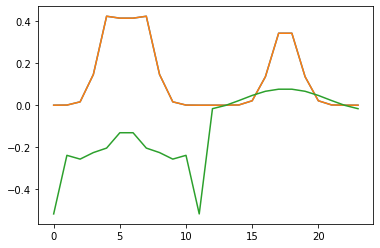

In [12]:

goal_d = np.diag(one_rdm_full.real)
print(sum(goal_d))
def func(vp, t, rdm):
    first_part = np.trace(np.matmul(t + np.diag(vp/np.sqrt(np.diag(rdm))), rdm))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=3, which='SA')
    return first_part - e[0]-e[1]-e[2]
def jac(vp, t, rdm):
    jacvals = np.zeros(len(vp))
    e, phi = eigsh(t + np.diag(vp/np.sqrt(np.diag(rdm))), k=3, which='SA')
    for i, v in enumerate(vp):
        jacvals[i] = rdm[i,i]/np.sqrt(rdm[i,i])
        jacvals[i] -= (1*phi[i,0]**2+1*phi[i,1]**2+phi[i,2]**2)/np.sqrt(rdm[i,i])
    return jacvals
vpar = np.sqrt(np.diag(one_rdm_full))
result = minimize(func, vpar, args=(sysparams.t, one_rdm_full.real), jac=jac, method="L-BFGS-B", tol=1.e-14, options={"disp": False, "maxiter": 1000, "gtol": 1e-9})
print(result)
print(vpar)
#pl.plot(dvrpts_s, result.x/np.sqrt(np.diag(one_rdm))-vpot_harm(dvrpts_s, 1))

e, phi = eigsh(sysparams.t.real + np.diag(result.x/np.sqrt(np.diag(one_rdm_full.real))), k=3, which="SA")

ksdens = (phi[:,0]*phi[:,0]+phi[:,1]*phi[:,1]+phi[:,2]*phi[:,2]).flatten().real
print('derr', np.linalg.norm(ksdens-goal_d))
coul = vinteract_harm(dvrpts_s).reshape((n_pts_s, n_pts_s))@(goal_d[:n_pts_s]+goal_d[n_pts_s:])
coulf = np.kron(z, coul) + np.kron(o, coul)
pl.plot(sysparams.xlattice, ksdens, sysparams.xlattice, goal_d, sysparams.xlattice, result.x/np.sqrt(np.diag(one_rdm_full))-sharedvals.vin-coulf/2)
pl.show()
#print(sum((2*(phi[:,0]**2)+1*(phi[:,1]**2)).flatten().real))

In [13]:
#next 5 are required to develop and advance KS orbitals
dpe=np.zeros(sysparams.ntot1,dtype=np.float64) #current density
dnx=np.zeros(sysparams.ntot1,dtype=np.float64) #current derivative of density
ddnx=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density
dpenew=np.zeros(sysparams.ntot1,dtype=np.float64) #density after time step dt, taken from sysparams.dt
ddnxnew=np.zeros(sysparams.ntot1,dtype=np.float64) #second derivative of density after time step sysparams.dt

#placeholder for advancing full system
psinew=np.zeros(sysparams.ntot,dtype=np.complex128)
psinew2 = np.zeros(sysparams.ntot, dtype=np.complex128)


td.density.fullwf_density(sysparams,fullvals.psi,dpe)

#initialize KS orbitals system to match dpe
KSvals=td.initial_states.initializekssystem(sysparams,sharedvals,dpe,fullvals)
o = np.array([1, 0])
z = np.array([0, 1])
KSvals.phi[:, 0] = phi[:,0]#np.kron(o, phi[:, 0])
KSvals.phi[:, 1] = phi[:,1]#np.kron(z, phi[:, 0])
KSvals.phi[:, 2] = phi[:,2]#np.kron(o, phi[:, 1])
#KSvals.phi[:, 3] = np.kron(z, phi[:, 1])
#vks1 = result.x/np.sqrt(np.diag(one_rdm))
#print(vks1)
KSvals.vks[:] = result.x/np.sqrt(np.diag(one_rdm_full)) #np.kron(o, vks1) + np.kron(z, vks1)
sharedvals.vin[:] = np.kron(o, vpot_harm(dvrpts_s, 1)) + np.kron(z, vpot_harm(dvrpts_s, 1))
sharedvals.v1[:] = sharedvals.vin[:]


 Calculating initial corresponding KS state


/var/folders/dg/qjq47mdj0rg7svj15wzvmnhr0000gp/T/ipykernel_69415/431952759.py:25: ComplexWarning: Casting complex values to real discards the imaginary part
  KSvals.vks[:] = result.x/np.sqrt(np.diag(one_rdm_full)) #np.kron(o, vks1) + np.kron(z, vks1)


In [14]:
def makefocklist(M,N):
    # integer, intent(in) :: M,N
    # integer, allocatable :: plist(:,:),flist(:,:)
    # integer, intent(out) :: tot
    # integer:: the_list(M),str_builder(N),jin,prev,l
    the_list = np.zeros(M, dtype=int)
    for l in range(M):
       the_list[l]=l+1
    jin=0
    prev=0 
    tot=[]
    #countnchoosek(M,N,jin,prev,tot)
    str_builder = [0]*N
    
    plist = []
    jin = 0
    prev = 0
    tot = []
    buildnchoosek(the_list,N,str_builder,plist,jin,prev,tot)
    return plist
def countnchoosek(size_the_list,kin,j,prev,tot):
    if (j==kin):
      tot += [1]
      return
    else:
       for i in range(prev+1,size_the_list+1):
          j=j+1
          countnchoosek(size_the_list,kin,j,i,tot)
          j=j-1

def buildnchoosek(the_list,kin,str_builder,plist,j,prev,tot):
    if (j==kin):
       tot+= [1]
       plist += [str_builder.copy()]
       return
    else:
       for i in range(prev+1, len(the_list)+1):
          j=j+1
          str_builder[j-1] = the_list[i-1]
          buildnchoosek(the_list,kin,str_builder,plist,j,i,tot)
          j=j-1

occlista = makefocklist(n_pts_s, sysparams.nalpha)
occlistb = makefocklist(n_pts_s, sysparams.nbeta)
occlist = []
for occa in occlista:
   for occb in occlistb:
      occlist.append(occa+[o+n_pts_s for o in occb])
print(len(occlist))
print(sysparams.ntot)

792
792


[ 5.04392453e-17  5.68761195e-17 -6.87775871e-17  8.96853773e-16
 -9.40627927e-15  7.52768849e-15 -5.31584783e-15  4.79461478e-15
 -8.27804244e-15  2.68259848e-15 -4.26962328e-17 -2.48705157e-17
 -7.42614064e-18  9.98898675e-18 -4.28242138e-16 -9.55058586e-16
 -2.95174751e-15  5.45586658e-15 -3.57543620e-15  3.01652735e-16
 -1.17334845e-15 -2.30781296e-16 -7.78510235e-18 -1.40437255e-18]


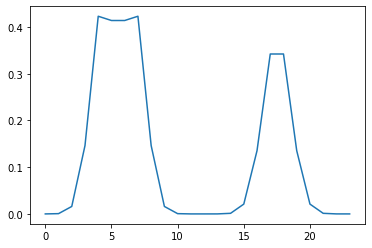

In [15]:
import matplotlib.pyplot as pl
td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,ddnx)
td.density.fullwf_density(sysparams, fullvals.psi,  dpe)
pl.plot(dpe)
print(ddnx)

In [16]:
vinit = np.zeros(sysparams.ntot)
vfin = np.zeros(sysparams.ntot)
vin = np.zeros(sysparams.ntot)
for i, occ in enumerate(occlist):
    for o in occ:
        vinit[i] += sharedvals.v1[o-1]

vfin = vinit*1.1

def adiapot(t):
    b = 0.2
    a = 25
    func = 1/(1+np.exp(-b*(t-a)))
    dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    th = t/ttime
    func = 6*th**5-15*th**4+10*th**3
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    pot = (1-func)*vinit + func*vfin
    dpot = -dfunc*vinit + dfunc*vfin
    return pot, dpot

vinit1 = vpot_harm(dvrpts_s, 1)
vfin1 = vpot_harm(dvrpts_s, 1.1)

def adiapot1(t):
    b = 0.2
    a = 25
    func = 1/(1+np.exp(-b*(t-a)))
    dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    th = t/ttime
    func = 6*th**5-15*th**4+10*th**3
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    pot = (1-func)*vinit1 + func*vfin1
    dpot = -dfunc*vinit1 + dfunc*vfin1
    return pot, dpot

o = np.array([1, 0])
z = np.array([0, 1])
vinit1l = np.kron(o, vpot_harm(dvrpts_s, 1)) + np.kron(z, vpot_harm(dvrpts_s, 1))
vfin1l = np.kron(o, vpot_harm(dvrpts_s, 1.1)) + np.kron(z, vpot_harm(dvrpts_s, 1.1))

def adiapot1l(t):
    b = 0.2
    a = 25
    func = 1/(1+np.exp(-b*(t-a)))
    dfunc = b*np.exp(-b*(t-a))/((1+np.exp(-b*(t-a)))**2)
    th = t/ttime
    func = 6*th**5-15*th**4+10*th**3
    print(func)
    dfunc = (6*5*th**4-15*4*th**3+10*3*th**2)/ttime
    pot = (1-func)*vinit1l + func*vfin1l
    dpot = -dfunc*vinit1l + dfunc*vfin1l
    return pot, dpot

v1save = sharedvals.v1.copy()
sharedvals.v1[:] = 0
sharedvals.vin[:] = 0

In [17]:


            #print(str(np.binary_repr(i, width=n_pts_s*2)))
            #print(vnum, sum([int(i) for i in str(np.binary_repr(i, width=n_pts_s*2))]))
            #break
            
fsum = 0
sysparams.dt=sysparams.dth
info=td.propagate.advancekssystem(dpe,dpenew,dnx,ddnx,ddnxnew,sysparams,KSvals,sharedvals)
result.x = KSvals.vks*np.sqrt(np.diag(one_rdm_full))
sysparams.ct = 0.
sysparams.energy = (np.dot(KSvals.phi[:,0],sysparams.t@KSvals.phi[:,0]+KSvals.vks*KSvals.phi[:,0])+
                    np.dot(KSvals.phi[:,1],sysparams.t@KSvals.phi[:,1]+KSvals.vks*KSvals.phi[:,1])+
                    np.dot(KSvals.phi[:,2],sysparams.t@KSvals.phi[:,2]+KSvals.vks*KSvals.phi[:,2]))
sysparams.energynew = sysparams.energy
for loop in range(n_steps+1):
    print('\n')
    print('For time '+str(sysparams.ct)+' to ',str(sysparams.ct+sysparams.dt))
    
    # generate wavefunction at ct+dt
    #td.propagate.advancewf(sysparams,sharedvals,25,fullvals.v,fullvals.psi,psinew)
    vks, dvks = adiapot(sysparams.ct)
    vksnew, dvksnew = adiapot(sysparams.ct+sysparams.dt)
    
    #dvks = vks*0
    #dvksnew = vks*0
    sharedvals.v1[:] = 0*v1save
    td.propagate.advancewftd_sq(sysparams,sharedvals,30,fullvals.v,vks,vksnew,fullvals.psi, psinew,dvks,dvksnew)
    #sharedvals.v1[:] = v1save
    #td.propagate.advancewf(sysparams,sharedvals,20,fullvals.v,fullvals.psi,psinew2)
    sharedvals.v1[:] = adiapot1l(sysparams.ct)[0].copy()


    
    #Calculate density, first derivative of density and second derivative of density 
    #at time ct using psi
    td.density.fullwf_density(sysparams,fullvals.psi,dpe)
    td.density.calcdnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,dnx)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,fullvals.psi,fullvals.v,ddnx)

    v1cur = adiapot1l(sysparams.ct)[0]
    #info2 = td.propagate.advancekssystem(dpenew,dpenew,dnx*0,ddnx*0,ddnxnew*0,sysparams2,KSvals2,sharedvals)
    fadd = sysparams.dt*np.dot(dnx, KSvals.vks-v1cur)
    fsum += fadd

    v1cur = adiapot1l(sysparams.ct+sysparams.dt)[0]
    sysparams.energynew = sysparams.energy + fadd
    
    sharedvals.v1 = adiapot1l(sysparams.ct+sysparams.dt)[0].copy()
    #Calculate density and second derivative of density at time ct+dt using psinew
    td.density.fullwf_density(sysparams,psinew,dpenew)
    td.density.calcddnx(sysparams,sharedvals,sysparams.ntot1,psinew,fullvals.v,ddnxnew)
    
    #Attempt to advance KS system
    info=td.propagate.advancekssystem(dpe,dpenew,dnx,ddnx,ddnxnew,sysparams,KSvals,sharedvals)
    
    if (info==1):#succesful advance of orbitals shift full wavefunction
        fullvals.psi=psinew
        sysparams.energy = 1*sysparams.energynew

 Assigning phases
 Initial phases error   0.0000000000000000     
 Final phases error   0.0000000000000000     
 Starting advance of KS orbitals
     iteration difference =  1.8257645198E-10
     iteration difference =  1.8675413658E-18
     iteration difference =  1.6680104139E-25
     iteration difference =  3.8756723288E-32
     iteration difference =  1.3619784286E-38
 Orbitals converged, recalculate potential
     iteration difference =  1.0858685476E-28
 Potential Converged
     iteration difference =  3.1832935881E-35
 Orbitals and potential converged, Time step complete
 restart with dvks saved
 Density error for time step 1 = 2.9543214779E-08
 Check properties of orbitals
 Particle number   3.0000000000000027     
 Overlap matrix
  1.00E+00  2.11E-17  2.66E-16
  2.11E-17  1.00E+00  3.81E-16
  2.66E-16  3.81E-16  1.00E+00


For time 0.0 to  0.012
0.0
0.0
7.997600192000001e-11
7.997600192000001e-11


For time 0.012 to  0.024
 Assigning phases
 Initial phases error   0.0000000000

/Users/jamesbrown/Documents/Coding/TDDFTinversion/python/TDDFTinversion.py:284: ComplexWarning: Casting complex values to real discards the imaginary part
  _TDDFTinversion.f90wrap_systemparameters__set__energy(self._handle, energy)


7.997600192000001e-11
7.997600192000001e-11
6.396160614400001e-10
6.396160614400001e-10
 Assigning phases

 Initial phases error   3.9141247337741679E-012
 Final phases error   2.1102413683098244E-017
 Starting advance of KS orbitals
     iteration difference =  1.8257645198E-10
     iteration difference =  1.8675413712E-18
     iteration difference =  1.6680082227E-25
     iteration difference =  3.8774494216E-32
     iteration difference =  1.1204797738E-38
 Orbitals converged, recalculate potential
     iteration difference =  2.7997319699E-27
 Potential Converged
     iteration difference =  9.1752428082E-35
 Orbitals and potential converged, Time step complete
 Density error for time step 3 = 2.9542758808E-08
 Check properties of orbitals
 Particle number   3.0000000000000040     
 Overlap matrix
  1.00E+00  2.11E-17  4.95E-16
  2.11E-17  1.00E+00  3.81E-16
  4.95E-16  3.81E-16  1.00E+00

For time 0.024 to  0.036000000000000004
6.396160614400001e-10
6.396160614400001e-10
2.1580564

/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


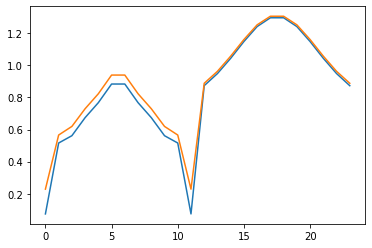

In [18]:
pl.plot(sysparams.xlattice, KSvals.vks-vfin1l, sysparams.xlattice, result.x/np.sqrt(np.diag(one_rdm_full))-vinit1l)
#pl.plot(sharedvals.vinteract)

In [19]:
print(fsum)

0.008052302011833785


In [20]:
psifin = np.zeros(len(fullvals.psi), dtype=np.complex128)
sharedvals.v1[:] = vfin1l
td.secondquant_wrap.calc_ground_state(sysparams, sharedvals, 2*n_pts_s, 30, psifin)

 eig   3.8969457002684029        4.8725483593586434        4.9457100144593165        5.8554574142266214        5.8920270119351636     


2.4074667247315957e-06


/Users/jamesbrown/Documents/Coding/environments/qsdkmain/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


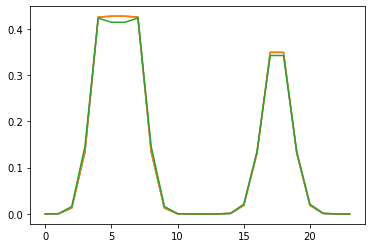

In [21]:
E, V = np.linalg.eigh(sysparams.t+np.diag(KSvals.vks[:]))#np.diag(result.x/np.sqrt(np.diag(one_rdm))))
td.density.fullwf_density(sysparams,fullvals.psi,dpenew)
#dpesum = np.zeros(n_pts_s)
#for i in range(n_pts_s):
#    dpesum[i] = dpenew[i]+dpenew[i+n_pts_s]
pl.plot(sysparams.xlattice, dpenew, sysparams.xlattice, V[:,0]**2+V[:,1]**2+V[:,2]**2, sysparams.xlattice, np.diag(one_rdm_full))
print(np.linalg.norm(dpenew-V[:,0]**2-V[:,1]**2-V[:,2]**2))
#print(E[0]+E[1]*2)
#print('over', np.abs(np.dot(wavesf[:,0], psinew)))
#goales,waves = eigsh(t2+np.diag(vin+vksnew), k=2, which='SA')
#print(goales)
#print(goalf)
#print(2*np.dot(V[:,0],sysparams.t@V[:,0]+vext_final1*V[:,0])-goales[0]-exc-fsum)
adiafinal = np.dot(V[:,0],sysparams.t@V[:,0]+v1cur[:]*V[:,0])+np.dot(V[:,1],sysparams.t@V[:,1]+v1cur[:]*V[:,1])+fsum+np.dot(V[:,2],sysparams.t@V[:,2]+v1cur[:]*V[:,2])
#print(2*np.dot(V[:,0],sysparams.t@V[:,0]+vext_final1*V[:,0])-goales[0]-exc+fsum)

In [22]:
adiainit = (np.dot(phi[:,0],sysparams.t@phi[:,0]+vinit1l*phi[:,0])+np.dot(phi[:,1],sysparams.t@phi[:,1]+vinit1l*phi[:,1])+
            np.dot(phi[:,2],sysparams.t@phi[:,2]+vinit1l*phi[:,2]))

In [23]:
adiafinal-adiainit

0.12960073379889847

In [28]:
3.8969457002684029-3.7673452339712270

0.12960046629717592

In [26]:
0.1295903226131312-0.12959003744080677

2.8517232442126783e-07

In [24]:
su = 0
for a in [0,2]:
    for b in [1]:
        su += np.dot(V[:n_pts_s,a],V[n_pts_s:,b])
(1/2*(1/2+1))+1-su

0.7500750285803267

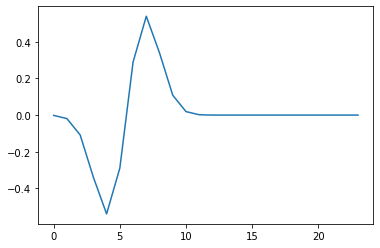

In [27]:
plt.plot(V[:,2])